In [4]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from dlomix.losses import masked_spectral_distance, masked_pearson_correlation_distance
from dlomix.data import FragmentIonIntensityDataset

import os

2024-09-12 15:59:44.546431: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 15:59:44.591266: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 15:59:44.591298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 15:59:44.593281: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-12 15:59:44.601423: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 15:59:44.602273: I tensorflow/core/platform/cpu_feature_guard.cc:1


Avaliable feature extractors are (use the key of the following dict and pass it to features_to_extract in the Dataset Class):
{
   "atom_count": "Atom count of PTM.",
   "delta_mass": "Delta mass of PTM.",
   "mod_gain": "Gain of atoms due to PTM.",
   "mod_loss": "Loss of atoms due to PTM.",
   "red_smiles": "Reduced SMILES representation of PTM."
}.
When writing your own feature extractor, you can either
    (1) use the FeatureExtractor class or
    (2) write a function that can be mapped to the Hugging Face dataset.
In both cases, you can access the parsed sequence information from the dataset using the following keys, which all provide python lists:
    - _parsed_sequence: parsed sequence
    - _n_term_mods: N-terminal modifications
    - _c_term_mods: C-terminal modifications



In [16]:
# get files in the directory
run_name = "c_i_FiLM_full_d10_static_0.0005_ITy"

subdir = '/cmnfs/proj/prosit_astral/saved_models/%s/' % (run_name)

files = [ os.path.join(subdir, file_name) for file_name in os.listdir(subdir) ] 
files.sort(reverse=True)

print('\n'.join(files))
print(len(files))

/cmnfs/proj/prosit_astral/saved_models/c_i_FiLM_full_d10_static_0.0005_ITy/0.5393_c_i_FiLM_full_d10_static_0.0005_ITy.keras
/cmnfs/proj/prosit_astral/saved_models/c_i_FiLM_full_d10_static_0.0005_ITy/0.5191_c_i_FiLM_full_d10_static_0.0005_ITy.keras
/cmnfs/proj/prosit_astral/saved_models/c_i_FiLM_full_d10_static_0.0005_ITy/0.4934_c_i_FiLM_full_d10_static_0.0005_ITy.keras
/cmnfs/proj/prosit_astral/saved_models/c_i_FiLM_full_d10_static_0.0005_ITy/0.4694_c_i_FiLM_full_d10_static_0.0005_ITy.keras
/cmnfs/proj/prosit_astral/saved_models/c_i_FiLM_full_d10_static_0.0005_ITy/0.3584_c_i_FiLM_full_d10_static_0.0005_ITy.keras
/cmnfs/proj/prosit_astral/saved_models/c_i_FiLM_full_d10_static_0.0005_ITy/0.3429_c_i_FiLM_full_d10_static_0.0005_ITy.keras
/cmnfs/proj/prosit_astral/saved_models/c_i_FiLM_full_d10_static_0.0005_ITy/0.3319_c_i_FiLM_full_d10_static_0.0005_ITy.keras
/cmnfs/proj/prosit_astral/saved_models/c_i_FiLM_full_d10_static_0.0005_ITy/0.3233_c_i_FiLM_full_d10_static_0.0005_ITy.keras
/cmnfs/p

In [8]:
# Generate metadata combinations

charges = [
    [1,0,0,0,0,0],
    [0,1,0,0,0,0],
    [0,0,1,0,0,0],
    [0,0,0,1,0,0],
    [0,0,0,0,1,0],
    [0,0,0,0,0,1],
]
methods = [
    [1,0],
    [0,1]
]
machines = [
    [1,0,0],
    [0,1,0],
    [0,0,1]
]
energies = [x / 1000.0 for x in range(100, 500, 5)]

# Generate permutations
metadata_permutations = {
    'modified_sequence': [],
    'charge_oh': [],
    'collision_energy': [],
    'method_nr_oh': [],
    'machine_oh': [],
}
for charge in charges:
    for method in methods:
        for machine in machines:
            for energy in energies:
                metadata_permutations['charge_oh'].append(charge)
                metadata_permutations['method_nr_oh'].append(method)
                metadata_permutations['machine_oh'].append(machine)
                metadata_permutations['collision_energy'].append(energy)

for key,value in metadata_permutations.items():
    metadata_permutations[key] = np.array(value)

print(metadata_permutations['charge_oh'].shape)


(2880, 6)


In [20]:
# load all models

results = []

for file in files[::9]:
    model = keras.saving.load_model(file,
                                    custom_objects={'masked_spectral_distance': masked_spectral_distance, 
                                                    'masked_pearson_correlation_distance': masked_pearson_correlation_distance}, 
                                    compile=True, safe_mode=True)
    results.append(model.get_meta_vector(metadata_permutations))
    print("Finished loading model %s" % file.split('/')[-1])

Finished loading model 0.5393_c_i_FiLM_full_d10_static_0.0005_ITy.keras
Finished loading model 0.2790_c_i_FiLM_full_d10_static_0.0005_ITy.keras
Finished loading model 0.2278_c_i_FiLM_full_d10_static_0.0005_ITy.keras
Finished loading model 0.2041_c_i_FiLM_full_d10_static_0.0005_ITy.keras
Finished loading model 0.1933_c_i_FiLM_full_d10_static_0.0005_ITy.keras
Finished loading model 0.1865_c_i_FiLM_full_d10_static_0.0005_ITy.keras
Finished loading model 0.1830_c_i_FiLM_full_d10_static_0.0005_ITy.keras
Finished loading model 0.1794_c_i_FiLM_full_d10_static_0.0005_ITy.keras
Finished loading model 0.1757_c_i_FiLM_full_d10_static_0.0005_ITy.keras
Finished loading model 0.1722_c_i_FiLM_full_d10_static_0.0005_ITy.keras
Finished loading model 0.1687_c_i_FiLM_full_d10_static_0.0005_ITy.keras


In [334]:
res = tf.split(results[10], 20, axis=-1)

vals = [tf.math.abs(tf.reshape(res[i], [-1])) for i in range(0, 20, 2)]
keys = np.array([i for i in range(1, 11)])

std = [tf.math.reduce_mean(v) for v in vals]
plt.plot(keys, std)

IndexError: list index out of range

[(0.7, 0.7, 0.4895833333333333), (0.7, 0.7, 0.5), (0.7, 0.7, 0.5104166666666666), (0.7, 0.7, 0.5208333333333334), (0.7, 0.7, 0.53125), (0.7, 0.7, 0.5416666666666666), (0.7, 0.7, 0.5520833333333334), (0.7, 0.7, 0.5625), (0.7, 0.7, 0.5729166666666666), (0.7, 0.7, 0.5833333333333334), (0.7, 0.7, 0.59375), (0.7, 0.7, 0.6041666666666666), (0.7, 0.7, 0.6145833333333334), (0.7, 0.7, 0.625), (0.7, 0.7, 0.6354166666666666), (0.7, 0.7, 0.6458333333333334), (0.7, 0.7, 0.65625), (0.7, 0.7, 0.6666666666666666), (0.7, 0.7, 0.6770833333333334), (0.7, 0.7, 0.6875), (0.7, 0.7, 0.6979166666666666), (0.7, 0.7, 0.7083333333333334), (0.7, 0.7, 0.71875), (0.7, 0.7, 0.7291666666666666), (0.7, 0.7, 0.7395833333333334), (0.7, 0.7, 0.75), (0.7, 0.7, 0.7604166666666667), (0.7, 0.7, 0.7708333333333333), (0.7, 0.7, 0.78125), (0.7, 0.7, 0.7916666666666667), (0.7, 0.7, 0.8020833333333333), (0.7, 0.7, 0.8125), (0.7, 0.7, 0.8229166666666667), (0.7, 0.7, 0.8333333333333333), (0.7, 0.7, 0.84375), (0.7, 0.7, 0.8541666666

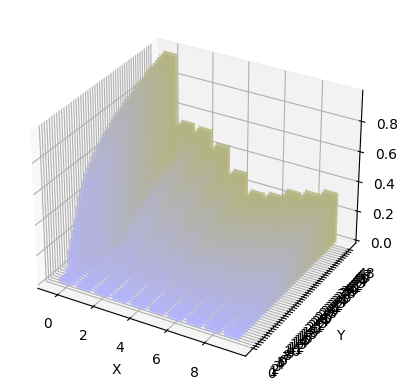

In [267]:
import matplotlib

# Fixing random state for reproducibility
np.random.seed(19680801)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colors = [(.7, .7, (i - 1) / 48.0 * 0.5 + 0.5) for i in range(len(results))]

print(colors)

yticks = list(reversed(list(range(len(results)))   ))

print(yticks)

for color, epoch in zip(colors, yticks):

    res = tf.split(results[epoch], 20, axis=-1)
    vals = [tf.math.abs(tf.reshape(res[i], [-1])) for i in range(0, 20, 2)]
    std = [tf.math.reduce_mean(v) for v in vals]


    xs = np.arange(10)

    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    cs = [c] * len(xs)
    cs[0] = 'c'

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    ax.bar(xs, std, zs=epoch, color=color, zdir='y', alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# On the y-axis let's only label the discrete values that we have data for.
ax.set_yticks(yticks)

plt.show()

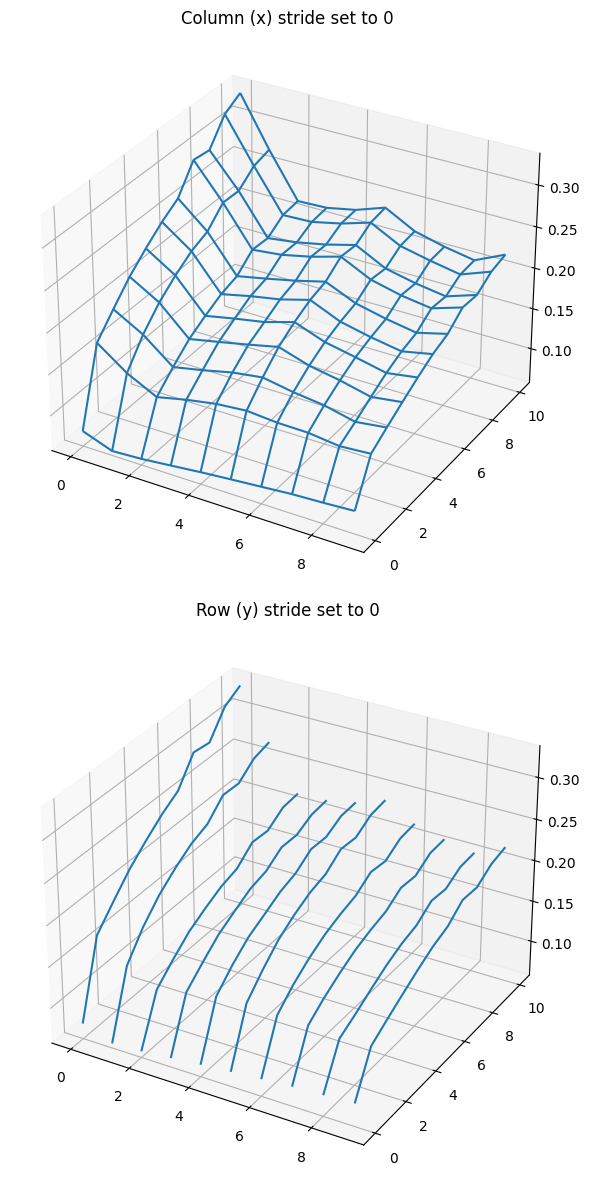

In [23]:
'''
===================================
3D wireframe plots in one direction
===================================

Demonstrates that setting rstride or cstride to 0 causes wires to not be
generated in the corresponding direction.
'''

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(8, 12), subplot_kw={'projection': '3d'})


X_ = []
Y_ = []
Z_ = []

# X_.append( list(range(10)) )
# Y_.append( [0] * 10 )
# Z_.append( [0] * 10 )

for step in range(len(results)):

    res = tf.split(results[step], 20, axis=-1)


    vals = [tf.reshape(res[i], [-1]) for i in range(0, 20, 2)]

    #vals = [tf.math.abs(v) for v in vals]

    std = [float(tf.math.reduce_std(v)) for v in vals]

    X_.append( list(range(len(std))) )

    Y_.append( [step] * len(std) )
    Z_.append( std )


# X_.append( X_[-1] )
# Y_.append( Y_[-1] )
# Z_.append( [0] * 10 )

# X_.append( list(range(10)) )
# Y_.append( [0] * 10 )
# Z_.append( [0] * 10 )

X_ = np.array(X_)
Y_ = np.array(Y_)
Z_ = np.array(Z_)

# print(X_)
# print(Y_)
# print(Z_)

# Give the first plot only wireframes of the type y = c
ax1.plot_wireframe(X_, Y_, Z_, rstride=1, cstride=1)
ax1.set_title("Column (x) stride set to 0")

# Give the second plot only wireframes of the type x = c
ax2.plot_wireframe(X_, Y_, Z_, rstride=0, cstride=1)
ax2.set_title("Row (y) stride set to 0")

plt.tight_layout()
plt.show()

In [227]:
model_name = '0.5344_c_r_FiLM_full_d10_static_0.0005_9kK.keras'

subdir = 'c' + model_name.split('_c')[1].split('.keras')[0]

print(subdir)


model = keras.saving.load_model('/nfs/home/students/d.lochert/projects/astral/dlomix-astral/saved_models/%s/%s' % (subdir, model_name),
                                custom_objects={'masked_spectral_distance': masked_spectral_distance, 'masked_pearson_correlation_distance': masked_pearson_correlation_distance}, 
                                compile=True, safe_mode=True)
model.summary()

c_r_FiLM_full_d10_static_0.0005_9kK
(1024, 30, 512)
(1024, 1, 5120)


KeyboardInterrupt: 

In [34]:
int_data = FragmentIonIntensityDataset.load_from_disk("/nfs/home/students/d.lochert/projects/astral/dlomix-astral/combined_dataset")

In [56]:
tmp = [m for m in int_data.tensor_train_data.take(42)][0][0]
tmp

{'modified_sequence': <tf.Tensor: shape=(1024, 30), dtype=int64, numpy=
 array([[ 5,  7,  2, ...,  0,  0,  0],
        [20,  6, 10, ...,  0,  0,  0],
        [20, 18,  4, ...,  0,  0,  0],
        ...,
        [13,  6, 14, ...,  0,  0,  0],
        [13, 16, 14, ...,  0,  0,  0],
        [ 6, 16,  7, ...,  0,  0,  0]])>,
 'charge_oh': <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
 array([[0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        ...,
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.]], dtype=float32)>,
 'collision_energy': <tf.Tensor: shape=(1024,), dtype=float32, numpy=array([0.29, 0.29, 0.3 , ..., 0.32, 0.3 , 0.28], dtype=float32)>,
 'method_nr_oh': <tf.Tensor: shape=(1024, 2), dtype=float32, numpy=
 array([[0., 1.],
        [0., 1.],
        [1., 0.],
        ...,
        [0., 1.],
        [1., 0.],
        [0., 1.]], dtype=float32)>,
 'machine_oh': <tf.Tensor: shape=(10

In [72]:
print(tmp['collision_energy'].numpy().min())
print(tmp['collision_energy'].numpy().max())

0.18
0.40184155


In [140]:
# Use permutations 

res = model.get_meta_vector(metadata_permutations)
res = tf.split(res, 20, axis=-1)

In [100]:
# Use data from dataset

tmp = [m for m in int_data.tensor_train_data.take(42)][0][0]

res = model.get_meta_vector(tmp)
res = tf.split(res, 20, axis=-1)

RuntimeError: pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL _NotOkStatusException REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /nfs/home/students/d.lochert/miniconda3/envs/astral/lib/python3.10/site-packages/tensorflow/python/eager/core.py(42): __init__
  /nfs/home/students/d.lochert/miniconda3/envs/astral/lib/python3.10/site-packages/tensorflow/python/ops/gen_dataset_ops.py(3024): iterator_get_next
  /nfs/home/students/d.lochert/miniconda3/envs/astral/lib/python3.10/site-packages/tensorflow/python/data/ops/iterator_ops.py(773): _next_internal
  /nfs/home/students/d.lochert/miniconda3/envs/astral/lib/python3.10/site-packages/tensorflow/python/data/ops/iterator_ops.py(810): __next__
  /tmp/ipykernel_410785/1894031175.py(3): <listcomp>
  /tmp/ipykernel_410785/1894031175.py(3): <module>
  /nfs/home/students/d.lochert/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3508): run_code
  /nfs/home/students/d.lochert/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3448): run_ast_nodes
  /nfs/home/students/d.lochert/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3269): run_cell_async
  /nfs/home/students/d.lochert/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /nfs/home/students/d.lochert/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3064): _run_cell
  /nfs/home/students/d.lochert/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3009): run_cell
  /nfs/home/students/d.lochert/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py(540): run_cell
  /nfs/home/students/d.lochert/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py(422): do_execute
  /nfs/home/students/d.lochert/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py(729): execute_request
  /nfs/home/students/d.lochert/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py(409): dispatch_shell
  /nfs/home/students/d.lochert/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py(502): process_one
  /nfs/home/students/d.lochert/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py(513): dispatch_queue
  /nfs/home/students/d.lochert/miniconda3/envs/astral/lib/python3.10/asyncio/events.py(80): _run
  /nfs/home/students/d.lochert/miniconda3/envs/astral/lib/python3.10/asyncio/base_events.py(1909): _run_once
  /nfs/home/students/d.lochert/miniconda3/envs/astral/lib/python3.10/asyncio/base_events.py(603): run_forever
  /nfs/home/students/d.lochert/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py(195): start
  /nfs/home/students/d.lochert/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py(725): start
  /nfs/home/students/d.lochert/.local/lib/python3.10/site-packages/traitlets/config/application.py(1043): launch_instance
  /nfs/home/students/d.lochert/.local/lib/python3.10/site-packages/ipykernel_launcher.py(17): <module>
  /nfs/home/students/d.lochert/miniconda3/envs/astral/lib/python3.10/runpy.py(86): _run_code
  /nfs/home/students/d.lochert/miniconda3/envs/astral/lib/python3.10/runpy.py(196): _run_module_as_main


{'bodies': [<matplotlib.collections.PolyCollection at 0x7f8c4c7a3ac0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f8c4c7a3970>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f8c4c6f3fd0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f8c4c6f3280>}

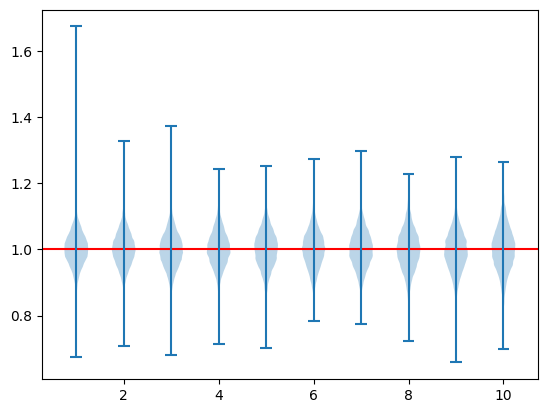

In [141]:
# Plot scaling vector
vals = [tf.reshape(res[i], [-1])+1 for i in range(0, 20, 2)]
keys = np.array([i for i in range(1, 11)])

plt.axhline(y=1, color='r', linestyle='-')
plt.violinplot(vals, keys) 

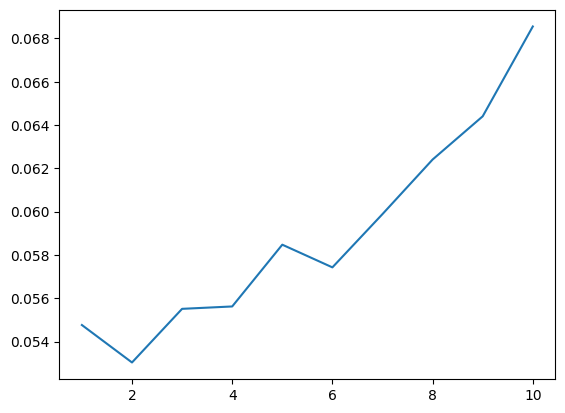

In [142]:
vals = [tf.reshape(res[i], [-1])+1 for i in range(0, 20, 2)]
keys = np.array([i for i in range(1, 11)])

std = [tf.math.reduce_std(v) for v in vals]
plt.plot(keys, std)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f8d982c0220>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f8d982c08e0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f8d982c29e0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f8d982c0be0>}

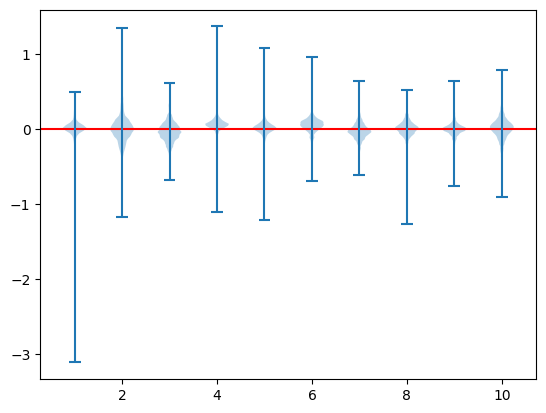

In [49]:
# Plot shift vector
vals = [tf.reshape(res[i], [-1]) for i in range(1, 20, 2)]
keys = np.array([i for i in range(1, 11)])

plt.axhline(y=0, color='r', linestyle='-')
plt.violinplot(vals, keys)

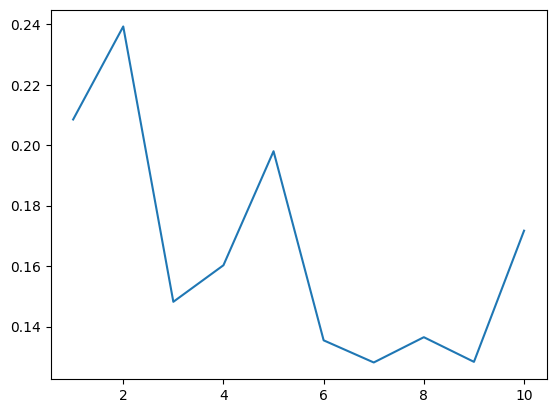

In [52]:
std = [tf.math.reduce_std(v) for v in vals]
plt.plot(keys, std)
